Notebook created by [Peter Belcák](https://disco.ethz.ch/members/pbelcak)

<br>

Updated:<br>

For FS24 by [Andreas Plesner](https://disco.ethz.ch/members/aplesner)

For HS24, FS25 by [Till Aczel](https://disco.ethz.ch/members/taczel)


# Hand-On Deep Learing - Introduction Session

This session will introduce you to the basic concepts of differentiable programming and traning neural networks from scratch. We will be using the popular deep learning framework PyTorch.


We will first talk about the bread-and-butter data type of deep learning - tensors. Once done, we will give a quick introduction to differentiable programs. On a simple example, we will show how to compute gradients in pytorch, and then lead you towards an implementation of a simple gradient descent training loop.

Having got a better feel of how one trains the parameters of a differentiable program, we will introduce neural networks. We will provide you with a full implementation of a training loop, and help you train an approximation of a Boolean function.

We will then steer away from illustrative examples and get started with practical, application-oriented deep learning. We will define and train both shallow and deep neural networks for image classification, tune the parameters of training and the sizes of architectures, and observe how the individual properties of our training setup influence the quality of the learning outcomes.

We will conclude this session with the introduction of convolutional layers. The challenge of the day will be to use convolutional neural networks to correctly classify greyscale images of fashion articles.

## Prelude: Tensors

In [ ]:
import torch
import torch.nn as nn

For training of deep models, `torch` uses a special data type: `torch.tensor`. The `torch.tensor` is `torch`'s way to store tensors which can be seen as multidimensional arrays, with the vector and matrix simply being the 1 and 2 dimensional instances. The values in `torch.tensor` can be learned from data.

Before we can move on to do anything more exciting, one has to know a bit about tensors. Anyone familiar with `numpy.ndarray` can skip to the last subsection on trainable tensors.

#### Tensors are an enhanced, uniform variant of multi-dimensional lists that torch operations can eat.

In [ ]:
A = [[ 0.0, 1.0], [ 1.0 , 0.0]]

try:
  torch.matmul(A, A) # throws a TypeError
except TypeError as error:
  print(f"An error occured in {error}")

An error occured in matmul(): argument 'input' (position 1) must be Tensor, not list


In [ ]:
A_tensor = torch.tensor(A)

torch.matmul(A_tensor, A_tensor)

tensor([[1., 0.],
        [0., 1.]])

Notice that nested lists that are candidates for tensors must be uniform in every dimension

In [ ]:
B = [
    [[1, 2, 3], [4, 5, 6]],
    [[0, 0], [1, 1]]
]


try:
  B_tensor = torch.tensor(B) # throws a ValueError
except ValueError as error:
  print(f"Could not form a tensor: {error}")

Could not form a tensor: expected sequence of length 3 at dim 2 (got 2)


**Exercise.** Create a tensor `I_tensor`, which is a 3x3 identity matrix.

In [ ]:
# Write your code here

I = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

I_tensor = torch.tensor(I)
print(I_tensor@I_tensor)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])


#### Tensors have a multi-dimensional `size`, also known as `shape`
The shape of a tensor describes the sizes of its individual tensor dimensions (also known as *axes*).

In [ ]:
A_tensor.shape

torch.Size([2, 2])

In [ ]:
A_tensor.size()

torch.Size([2, 2])

Notice that `A` consists of two lists containing two elements each.
Correspondingly, `A_tensor` has size of `[2, 2]`, meaning that `A_tensor` consists of two sub-tensors, namely `A_tensor[0]` and `A_tensor[1]`, containing two elements each.

In [ ]:
A_tensor[1]

tensor([1., 0.])

If we take `B` such that `B` contains two lists of lists, such as in

In [ ]:
B = [
    [[1, 2, 3], [4, 5, 6]],
    [[0, 0, 0], [1, 1, 1]]
]

Then we can turn it into a `B_tensor` of size `[2,2,3]`,

In [ ]:
B_tensor = torch.tensor(B)
B_tensor.shape

torch.Size([2, 2, 3])

... meaning that `B_tensor` consits of two two-dimensional sub-tensors, `B_tensor[0]`, and `B_tensor[1]`.

**Exercise.** What should be the shape of `I_tensor`?

In [ ]:
I_tensor_shape_intended = torch.Size( [ 3, 3 ] ) # modify this line with your guess

**Exercise.** Retrieve the shape of `I_tensor`.

In [ ]:
I_tensor_shape = I_tensor.shape # modify this line with the correct code

**Exercise.** Are they the same?

In [ ]:
# Run this code block.

if I_tensor_shape_intended == I_tensor_shape:
  print("I_tensor has shape as intended.")
else:
  print("I_tensor does not have shape as intended.")

I_tensor has shape as intended.


#### You can access arbitrary sub-tensors of every tensor

For this, you can use the python's usual slicing notation. For example, to get the second element of each of the deepest lists of `B` in the corresponding tensor, one can simply write

In [ ]:
B_tensor[:,:,1]

tensor([[2, 5],
        [0, 1]])

#### Tensors can be used in computations element-wise, as long as the dimensions match

In [ ]:
B_tensor + B_tensor ** 2 - 0.3 * B_tensor

tensor([[[ 1.7000,  5.4000, 11.1000],
         [18.8000, 28.5000, 40.2000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.7000,  1.7000,  1.7000]]])

**Exercise.** With the help of PyTorch documentation online, find the square root of $B^3$. All operations are applied element-wise

In [ ]:
B_tensor

tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[0, 0, 0],
         [1, 1, 1]]])

In [ ]:
# your solution
(B_tensor **3) ** (1/3)

tensor([[[1., 2., 3.],
         [4., 5., 6.]],

        [[0., 0., 0.],
         [1., 1., 1.]]])

#### Tensors can be either trainable or non-trainable

The trainable tensors are the ones that have `require_gradient` set to `True`.

In [ ]:
A_trainable = torch.tensor(A, requires_grad=True)

print(f"A_tensor is trainable: {A_tensor.requires_grad}")
print(f"A_trainable is trainable: {A_trainable.requires_grad}")

A_tensor is trainable: False
A_trainable is trainable: True


## Differentiable Functions and Why They Are So Special

The entire world is now interested in a particular sub-class of functions, called *differentiable functions*.

A differentiable functions is a function $f$ such that $f$ is differentiable with respect to its parameters. Here is an example of a differentiable function $f$ taking $x$ as input and multiplying it by a parameter $p$.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
p = torch.tensor([ 1.0 ], requires_grad=True)

def f(x):
  global p
  return p * x

Apart from forcing software engineers to dust off their high-school calculus knowledge, what are these differentiable programs actually good for? Why has the entire software engineering and data science world gone crazy over them?

We won't keep you in suspense, here's the "secret":

> Given input-output data, differentiable functions can be taught, through gradient descent, to use the right parameters, that is paramteres that extremise a (loss) function.

So, in the example of `f` above, we could train the function to learn the best value of `p`.

The method enabling this is known as gradient descent training. This has been covered well in many lectures and online resources. If you need a quick refresher, have a look through at the corresponding videos from the Computational Thinking course, available [here](https://disco.ethz.ch/courses/hs24/coti/). The short version is that we can update the parameter `p` using the update:

$p_{new} = p - ∇_pf(x)$

where $∇_p f(x)$ is the gradient of `f` with respect to `p` for the data `x`.

### Gradient Computation in PyTorch
At the helm of gradient-descent training in PyTorch is the `autograd` module. `torch.autograd` is PyTorch's automatic differentiation engine that powers gradient-descent training.

Suppose you take some trainable tensor $x$ and pass it through $f$.

In [ ]:
x = torch.tensor([ 5.1 ], requires_grad=True)
output = f(x)
output

tensor([5.1000], grad_fn=<MulBackward0>)

Notice that `output` now has an additional field, `grad_fn`, that was set by the `autograd` system to keep track of what operations have been performed on `x` to arrive at output.

Now, given some expected output for $f(x)$, say $1$, `autograd` allows you to compute an indication of how `p` needs to be changed in order for $f(x)$ to eventually yield the correct outputs. This is done in a process called *backward pass*.

In [ ]:
# define the output we expect. I.e. the output of f(x) with the correct p
expected_output = torch.tensor([1.0])
# compute the loss (how "bad" that output is for the current value of p)
loss = (output - expected_output) ** 2
# compute the gradient of f w.r.t. p
loss.backward()

This indication can then by inspected by asking `p` what its gradient is by reading `p.grad`.

In [ ]:
p.grad

tensor([41.8200])

This indication can be interpreted as

> Decreasing `p` by some small $\epsilon$ will decrease the loss by $41.82\epsilon$.

And, as you already know, leveraging the negation of gradient as the indication of the direction in which one should modify the parameters in order to descent towards lower values of the loss, gradient descent training is simply the routine under which one iteratively computes and then applies the gradient of the loss function with respect to parameters of the computation to minimise the loss.

**Exercise.** Fill in the code below to compute the gradients for `p` equal to `0.75`, `0.5`, `0.25`, `0.20` and `0.10`. What do you observe?

In [ ]:
# case p = 0.75
p = torch.tensor([ 0.75 ], requires_grad=True)
# you want something gradienty here - remember the backwards call :)
loss = (f(x) - expected_output) ** 2
loss.backward()

print(f"For p = 0.75, the gradient is {p.grad}")


# case p = 0.50
p = torch.tensor([ 0.50 ], requires_grad=True)
loss = (f(x) - expected_output) ** 2
loss.backward()

print(f"For p = 0.50, the gradient is {p.grad}")


# case p = 0.25
p = torch.tensor([ 0.25 ], requires_grad=True)
loss = (f(x) - expected_output) ** 2
loss.backward()

print(f"For p = 0.25, the gradient is {p.grad}")


# case p = 0.20
p = torch.tensor([ 0.20 ], requires_grad=True)
loss = (f(x) - expected_output) ** 2
loss.backward()

print(f"For p = 0.20, the gradient is {p.grad}")


# case p = 0.10
p = torch.tensor([ 0.10 ], requires_grad=True)
loss = (f(x) - expected_output) ** 2
loss.backward()

print(f"For p = 0.10, the gradient is {p.grad}")

For p = 0.75, the gradient is tensor([28.8150])
For p = 0.50, the gradient is tensor([15.8100])
For p = 0.25, the gradient is tensor([2.8050])
For p = 0.20, the gradient is tensor([0.2040])
For p = 0.10, the gradient is tensor([-4.9980])


### A Basic Training Loop
As hinted on by the above example, modifying the parameters of a differentiable program in the direction opposite to its gradient (i.e. in the direction in which the loss decreases most rapidly) generally guides the differentiable programs towards a minimum in the loss.

This process can be repeated iteratively, to form what is called a *training loop*. A typical training procedure of a differentiable program looks as follows:


1. Initialise the parameters of the differentiable program according to an appropriate scheme.
2. Take the inputs provided and perform a *forward pass* -- apply the program to the inputs.
3. Compute the loss between the expected outputs and the actual outputs of the program.
4. Compute the gradient of the loss with respect to the program's parameters.
5. Scale the gradients by the desired pace of descent -- *the learning rate* -- and update the parameters accordingly.
6. Repeat step 2 to 5 for a number of rounds or until the loss is sufficently small.


You already possess all the basic ingredients necessary to implement such a training procedure yourself. Let's do that.

#### Training loop without PyTorch

To get a feeling for how we can optimize the parameter `p` to some data we will start without the help PyTorch gives. We will still use PyTorch for tensor operations, but this could also be done using NumPy.

In [ ]:
def f(x, p):
    return x * p

def grad_f(x, p):
    return x

def loss_function(x, p, y):
    y_hat = f(x, p)
    errors = y_hat - y
    loss = torch.mean(errors**2)
    return loss

def grad_loss_function(x, p, y):
    y_hat = f(x, p)
    grad_y_hat = grad_f(x, p)
    errors = y_hat - y
    grad_errors = grad_y_hat
    grad_loss = torch.mean( 2*errors*grad_errors )
    return grad_loss


def training_loop(x, y, learning_rate: float = 0.1, number_of_iterations: int = 100):
    p = 0.9

    for iteration in range(number_of_iterations):
        # compute the gradient
        grad_loss = grad_loss_function(x, p, y)

        # log the result every 10th iteration
        if iteration%10 == 0:
            print(f"iteration: {iteration:3}, p: {p:5.3f}, gradient: {grad_loss}")

        # update p
        p = p - learning_rate * grad_loss

    return p

In [ ]:
p_true = 0.2 # the parameter value of p to be learned
datapoint_count = 10 # the number of datapoints to use for training in every iteration of the training loop

# Generate some artifical data. (datapoint_count, ) gives a one-dimensional array of length datapoint_count.
x = torch.rand(datapoint_count, requires_grad=False)
y = x * p_true

p_found = training_loop(x, y, learning_rate=1)
print(f"The true value is {p_true}, the value learned by gradient descent is {p_found}")

iteration:   0, p: 0.900, gradient: 0.29059097170829773
iteration:  10, p: 0.203, gradient: 0.0013610561145469546
iteration:  20, p: 0.200, gradient: 6.37252242086106e-06
iteration:  30, p: 0.200, gradient: 3.181057905976559e-08
iteration:  40, p: 0.200, gradient: 4.3690815410002415e-09
iteration:  50, p: 0.200, gradient: 4.3690815410002415e-09
iteration:  60, p: 0.200, gradient: 4.3690815410002415e-09
iteration:  70, p: 0.200, gradient: 4.3690815410002415e-09
iteration:  80, p: 0.200, gradient: 4.3690815410002415e-09
iteration:  90, p: 0.200, gradient: 4.3690815410002415e-09
The true value is 0.2, the value learned by gradient descent is 0.20000001788139343


**Exercise.** Play around with the number of iterations and learning rate. What happens if the learning rate is very high (>5) or very small (<1e-6)?


#### Training loop with PyTorch

We need to define the function using PyTorch's syntax.
A function in PyTorch is a `class` with a `forward` function.
Forward defines what should happen when you say `f(x)` and the building blocks
are the functions in `torch.nn`, e.g., `nn.Linear`. The next section will look at this in details

In [ ]:

class f_function(nn.Module):
    def __init__(self):
        super().__init__()
        # Make a linear function (y=ax+b) from input to output.
        # bias=False means b=0, so we get y = p*x
        self.p = nn.Linear(1, 1, bias=False)

        # set p to a fixed value
        # the torch.no_grad() removes gradient computations, so p.grad does not change
        with torch.no_grad():
            self.p.weight[0][0] = 0.9

    def forward(self, x):
        return self.p(x)

def train_f(x, y, learning_rate: float = 0.1, number_of_iterations: int = 100):
    # define the function
    f = f_function()
    # define the loss function as the mean squared loss
    loss_fn = nn.MSELoss()
    # define the optimizer as classic gradient decent
    optimizer = torch.optim.SGD(f.parameters(), lr=learning_rate)

    for iteration in range(number_of_iterations):
        # perform a "forward pass" (apply f to x)
        y_hat = f(x)

        # compute the loss
        loss = loss_fn(y_hat, y)

        # zero the gradients computed in the previous step
        optimizer.zero_grad()

        # calculate the gradients of the parameters of the net
        loss.backward()

        # use the gradients to update the weights of the network
        optimizer.step()

    # return p
    return f.p.weight[0][0]

**Exercise.** Complete the code below and compare the results to the implementation without PyTorch

In [ ]:
# pytorch needs the shape to be an array of shape (datapoint_count, 1)
x_pytorch = x.reshape( datapoint_count, 1 )
y_pytorch = y.reshape( datapoint_count, 1 )

p_found = train_f(x_pytorch, y_pytorch, learning_rate=1)
print(f"The true value is {p_true}, the value learned by gradient descent is {p_found}")

The true value is 0.2, the value learned by gradient descent is 0.20000001788139343


## Introducing Neural Networks
Neural networks are a particular class of differentiable programs, for which it has been theoretically proven that they can learn to approximate an arbitrary integrable function arbitrarily well, as long as they are given enough *representational power*.

*Here is where the deep learning black magic begins.*

Classical programs consist of a sequence of specific operations such as addition or conditional value assignment. Neural networks are differentiable programs that consist of a sequence of amenable elementary building blocks, traditionally referred to as *layers*, that can ultimately perform a wide variety of operations. The "bigger" these layers are, the more complex behaviour they can learn to exhibit.

There exists several popular types of neural network building blocks, including the trainable *linear layer*, or the non-trainable *activation*, *softmax*, and *dropout layers*, to name but a few. The combination of a linear layer and an activation layer is sometimes referred to as *dense layer* and is the basic building block of a *deep neural network*.

The amount of *representational power* network has is determined by the sizes of its trainable layers. Linear layers have a "width" (the number of constituent neurons). The wider the layer, the more fine-grained operation it is capable of representing. Whether it can learn to represent this operation is, however, an entirely different question.

In [1]:
import torch
import torch.nn as nn

### Constructing Neural Networks
Without further ado, let use these building blocks to form neural networks.

Knowing the format of the operation of individual layers, you could go ahead and implement them manually. To avoid uncanny detail, we will instead use the ready-made implementations of these layers from the `torch.nn` module.

In general, the [documentation](https://pytorch.org/docs/stable/nn.html) of the `torch.nn` module is what you want to turn to to understand a new layer type.

We walk you through creating instances of various layer types in the code below. We directly use the instances to operate input data.

#### Linear Layers

Let us begin with the most basic layer in deep learning, the Linear layer.

In [2]:
# construct a linear layer that takes a tensor of size (3,) and produces a
#  tensor of size (5,)
linear_layer = nn.Linear(3, 5)

# pass [1, 2, 3] through the layer
example_input = torch.tensor([ 1, 2, 3 ], dtype=torch.float)
linear_layer(example_input)

tensor([-1.3033,  0.1348,  1.5318, -0.0683,  0.8872], grad_fn=<ViewBackward0>)

Notice that as promised in the call to `nn.Linear(3, 5)`, the output tensor has 5 entries. Its output values are the result of an internal state (the layer *weights*) that has been initialised with random weights.

#### Activation Layers

Several types of activation layers exist, most notably the logistic sigmoid, rectified linear unit (ReLU), and the hyperbolic tangent. Each of these has a layer in `torch.nn`.

In [3]:
# construct a ReLU layer
relu_layer = nn.ReLU()

# pass [ -3, -2, -1, 0, +1, +2, +3 ] through the ReLU layer
example_input = torch.tensor([ -3, -2, -1, 0, +1, +2, +3 ], dtype=torch.float)
relu_layer(example_input)

tensor([0., 0., 0., 0., 1., 2., 3.])

In [4]:
# construct a sigmoid layer
sigmoid_layer = nn.Sigmoid()

# pass [ -3, -2, -1, 0, +1, +2, +3 ] through the sigmoid layer
sigmoid_layer(example_input)

tensor([0.0474, 0.1192, 0.2689, 0.5000, 0.7311, 0.8808, 0.9526])

In [5]:
# construct a tanh layer
tanh_layer = torch.nn.Tanh()

# pass [ -3, -2, -1, 0, +1, +2, +3 ] through the tanh layer
tanh_layer(example_input)

tensor([-0.9951, -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951])

As you can see, going from minus infinity towards infinity around 0, the ReLU transits from constant 0 to linear behaviour at 0, the logistic sigmoid proceeds to climb from 0 towards 1, and tanh climbs from -1 towards +1.

#### Dropout Layers

It is sometimes to the advantage of model training to "drop out" some of the incoming values at random. To this end, `torch.nn` provides the `Dropout` layer, which can be parameterised at construction with the probability of an input value being dropped out.

In [6]:
# construct a dropout layer with probability 0.5
dropout_layer = torch.nn.Dropout(p=0.5)

# pass [ -3, -2, -1, 0, +1, +2, +3 ] through the dropout layer
dropout_layer(example_input)

# with p=0.5, roughly half of the inputs should be dropped out on average,
#  and the remaining outputs are scaled up by 1/(1-p) == 2
# run this snippet multiple times to observe the effects of random dropout

tensor([-0., -0., -0., 0., 0., 0., 6.])

#### Softmax
The softmax function is used when we want to interpret an $n$-dimensional vector of real values as probabilities associated with $n$ discrete options. It helps determine the likelihood of each option possessing a certain property.

The softmax layer transforms the input $n$-dimensional vector into another $n$-dimensional vector, where all values lie between $0$ and $1$ and sum to $1$.

The larger an entry in the input vector is relative to the others, the closer its corresponding output value is to $1$.

In [7]:
# construct a softmax layer
softmax_layer = torch.nn.Softmax(dim=0)

# pass [ -3, -2, -1, 0, +1, +2, +3 ] through the softmax layer
softmax_layer(example_input)

tensor([0.0016, 0.0043, 0.0116, 0.0315, 0.0856, 0.2328, 0.6327])

In [8]:
# pass [ -1, 2, 5, 100 ] through the softmax layer
softmax_layer(torch.tensor([ -1, 2, 5, 100 ], dtype=torch.float))

tensor([1.4013e-44, 2.7465e-43, 5.5211e-42, 1.0000e+00])

### Putting the Layers Together -- Implementing a DNN


Neural networks are graphs of layers. In PyTorch, we generally tend to implement our neural networks as classes whose constructors construct the constituent parts of the network, and whose `forward` function passes the data through these parts.

Below is an example implementation of a shallow neural network. This network is *shallow* as it contains only one hidden trainable layer (=layer that is not an input or output layer).


In [9]:
class ShallowNeuralNet(nn.Module):
    def __init__(self, input_width: int, hidden_layer_width: int, output_width):
        super().__init__()
        self.hidden_layer = nn.Linear(input_width, hidden_layer_width)
        self.hidden_relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_width, output_width)

    def forward(self, input):
        hidden_trainable_output = self.hidden_layer(input)
        hidden_relu_output = self.hidden_relu(hidden_trainable_output)
        output = self.output_layer(hidden_relu_output)
        return output

Once the network behaviour has been described in this fashion, we can create an instance of the entire network at once and use it to process data in exactly the same way as we would use layers.

In [10]:
shallow_nn_instance = ShallowNeuralNet(5, 10, 2)

example_input = torch.ones(5)
shallow_nn_instance(example_input)

tensor([-0.1283, -0.1558], grad_fn=<ViewBackward0>)

**Exercise.** Complete the forward pass below to arrive at an implementation of a deep ReLU neural networks with layer profile given by a list of integers.

In [2]:
class DeepNeuralNet(nn.Module):
  def __init__(self, input_width, hidden_layer_profile, output_width, output_activation=None):
    super().__init__()
    self.layers = nn.ModuleList()

    # create the first hidden layer
    self.layers.append(nn.Linear(input_width, hidden_layer_profile[0]))
    self.layers.append(nn.ReLU())

    # create the internal hidden layers
    for in_width, out_width in zip(hidden_layer_profile[0:-1], hidden_layer_profile[1:]):
      self.layers.append(nn.Linear(in_width, out_width))
      self.layers.append(nn.ReLU())

    self.layers = nn.Sequential(*self.layers)

    # create the output layer
    self.output_layer = nn.Linear(hidden_layer_profile[-1], output_width)
    self.output_activation = nn.Identity() if not output_activation else output_activation

  def forward(self, input):
    x = input

    # loop through the layers to produce the output of the hidden network
    for layer in self.layers:
      x = layer(x)

    # TODO: produce the output of the network from the intermediate output of the last hidden layer
    output_before_activation = self.output_layer(x)

    # TODO: engage the optional activation in self.output_activation on the output_before_activation
    output = self.output_activation(output_before_activation)

    return output

**Exercise.** Test the class for generic deep neural networks below. Does everything work as expected?


In [12]:
# try passing a tensor of random numbers through the network
input1 = torch.rand((10,))
deep_nn_instance = DeepNeuralNet(input_width=10, hidden_layer_profile=[10, 7, 5], output_width=1)

deep_nn_instance(input1)

tensor([0.3156], grad_fn=<ViewBackward0>)

### A Training Loop for Neural Networks
In a previous section concerning differentiable functions, we introduced the intuition for using the gradient information due to a choice of loss function to find optimal parameters of a differentiable function.

This is exactly what we do for neural networks as well in order to train them to have the behaviour we desire of them.

We give code for optimisation of a neural network `net` with particular loss function `loss` on dataset loaded by a `dataloader` below, and comment on it step by step.

In [3]:
# Use the gpu if you are connected to a runtime with one.
# This is highly recommended, as it makes computations much faster
# (especially later on for the larger models)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def training_loop(
        dataloader: torch.utils.data.DataLoader,
        net: nn.Module,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        verbosity: int=3,
        device = DEVICE):
    size = len(dataloader.dataset)
    last_print_point = 0
    current = 0

    acc_loss = 0
    acc_count = 0
    net.train()
    # for every slice (X, y) of the training dataset
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # perform a forward pass to compute the outputs of the net
        pred = net(X)

        # calculate the loss between the outputs of the net and the desired outputs
        loss_val = loss_fn(pred, y)
        acc_loss += loss_val.item()
        acc_count += 1

        # zero the gradients computed in the previous step
        optimiser.zero_grad()

        # calculate the gradients of the parameters of the net
        loss_val.backward()

        # use the gradients to update the weights of the network
        optimiser.step()

        # compute how many datapoints have already been used for training
        current = batch * len(X)

        # report on the training progress roughly every 10% of the progress
        if verbosity >= 3 and (current - last_print_point) / size >= 0.1:
            loss_val = loss_val.item()
            last_print_point = current
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")
    return acc_loss / acc_count

We now possess all the tools necessary for constructing simple neural networks and for training them towards some particular behaviour by gradient descent loss minimisation. Let us put these tools to good use.

### Learning a Boolean Function



Let us consider the problem of learning a random Boolean function $f: \left\{ 0,1 \right\}^n \to \left\{ 0,1 \right\}^n$. It might sound a bit boring at first, but bear with us, as it is a very natural and tractable example for the examination of the representational power of various types of neural networks.

In [6]:
def make_binary_array(number: int, length: int) -> list:
	return [ (number>>k)&1 for k in range(0, length) ]

data_x_list = []

for i in range(0, 256):
  data_x_list.append(make_binary_array(i, 8))

data_x = torch.tensor(data_x_list, dtype=torch.float)
data_y = torch.randint(low=0, high=2, size=(256, 8)).type(torch.float)
# Move data to compute device
data_x = data_x.to(DEVICE)
data_y = data_y.to(DEVICE)

dataset = torch.utils.data.TensorDataset(data_x, data_y)

The above code generates a dataset of $(x, y)$ pairs where $x$ is any $n=8$-bit signal and $y = f(x)$, with $f$ chosen uniformly at random.

Given these examples, can we learn a neural network that performs the function of $f$? Yes! Just run the code below

In [8]:
def testing_loop(dataloader, net, device = DEVICE):
  size = len(dataloader.dataset)
  last_print_point = 0
  current = 0

  acc_correct = 0
  acc_count = 0

  net.eval()
  # for every slice (X, y) of the training dataset
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # perform a forward pass to compute the outputs of the net
        pred = net(X)

        # round the predictions (0 - 0.5 towards zero, >0.5 towards one)
        pred_rounded = torch.round(pred)

        # compute the number of correct entries
        acc_correct += torch.count_nonzero(pred_rounded == y).item()
        acc_count += y.numel()


  return acc_correct / acc_count

In [4]:
from tqdm import tqdm

def train(dataloader, net, loss_fn, optimiser, epochs, epoch_frequency=50, device=DEVICE, verbosity=3):
  least_loss = None
  if verbosity < 2:
    for t in tqdm(range(epochs), desc="Training Progress", unit=" epochs"):
      mean_loss = training_loop(dataloader, net, loss_fn, optimiser, verbosity=verbosity)
      accuracy = testing_loop(dataloader, net)
      if not least_loss or mean_loss < least_loss:
        least_loss = mean_loss
  else:
    for t in range(epochs):
        if verbosity >= 3:
          print(f"Epoch {t+1}\n-------------------------------")

        mean_loss = training_loop(dataloader, net, loss_fn, optimiser, verbosity=verbosity)
        accuracy = testing_loop(dataloader, net)
        if not least_loss or mean_loss < least_loss:
          least_loss = mean_loss

        if verbosity >= 2 and t%epoch_frequency == 0:
          print(f"Epoch {t:4}: mean loss {mean_loss:.5f}, validation accuracy {accuracy:7.2%}")
        if verbosity >= 3:
          print("\n")

  if verbosity >= 1:
    print(f"\nTraining complete, least loss {least_loss}, final validation accuracy {accuracy:.2%}")

  return least_loss

In [9]:
net = DeepNeuralNet(input_width=8, hidden_layer_profile=[256], output_width=8, output_activation=nn.Sigmoid()).to(DEVICE)

training_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(net.parameters(), lr=2e-2)

least_loss = train(training_dataloader, net, loss_fn, optimiser, epochs=400, verbosity=1)


Training Progress: 100%|██████████| 400/400 [00:08<00:00, 47.46 epochs/s]


Training complete, least loss 0.0009081615571631119, final validation accuracy 100.00%


Okay, this is encouraging. We are getting a loss in the order of $10^{-3}$ (which is relatively little for mean binary cross-entropy) and 100% accuracy. You will notice that as the training progresses, the loss tends to decrease and the accuracy increases. You will also notice that our neural network has only one hidden layer of 256 neurons. But are all those neurons really necessary?

Let's push things to an extremum and consider a network that has exactly one neuron in its hidden layer. In other words, all of the information about the input the output neurons have must be contained in exactly one activated number, and the hidden layer of such a network is an information bottleneck. All other parameters constant, what sort of loss values and accuracies will we be getting under such circumstances?

In [20]:
slender_net = DeepNeuralNet(input_width=8, hidden_layer_profile=[ 1 ], output_width=8, output_activation=nn.Sigmoid()).to(DEVICE)

training_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(slender_net.parameters(), lr=2e-2)

least_slender_loss = train(training_dataloader, slender_net, loss_fn, optimiser, epochs=400, verbosity=1)

Training Progress: 100%|██████████| 400/400 [00:07<00:00, 53.31 epochs/s]


Training complete, least loss 0.6861061975359917, final validation accuracy 54.64%


We see that with one hidden neuron, we learn to predict the values of $f(x)$ only marginally better than a coin flip, and that this corresponds to a relatively large value of the binary cross-entropy loss.

Okay. So there is a number of hidden neurons (256) that is sufficient for learning $f$ with 100% accuracy, and there is a number of hidden neurons (1) that is clearly insufficient to learn anything but some rough indication of the correct output.

*   With one hidden neuron, we have starved the network of representational power to the extent that it is only slightly better than tossing a fair coin at predicting $f$.
*   With 256 hidden neurons, we have given the network enough representational power to learn $f$. Perhaps even too much.

What happens in between these two extrema? And, is there a number of neurons beyond which the network fails to learn $f$ correctly but for which $f$ can still be learned?

**Exercise.** Find the least number of neurons $w_1$ such that the training of a shallow neural network with $w$ hidden neurons can still learn to execute $f$ with loss of at most $0.001$. Remember that you can adjust the learning rate and the number of epochs to get finer and more resource-efficient training. You can also set `verbosity=1` to avoid long listings of losses, though verbosity of above `1` might help with the investigation of whether the training losses plateau out.

You can also play with the number of epochs and learning rate to ensure the model has finished training.

In [37]:
w_1 = 256
least_loss = 1
training_dataloader = torch.utils.data.DataLoader(dataset, batch_size=12, shuffle=True)
loss_fn = nn.BCELoss()

net = DeepNeuralNet(input_width=8, hidden_layer_profile=[ w_1 ], output_width=8, output_activation=nn.Sigmoid()).to(DEVICE)

optimiser = torch.optim.Adam(net.parameters(), lr=.01)
least_loss = train(training_dataloader, net, loss_fn, optimiser, epochs=500, verbosity=1)

Training Progress: 100%|██████████| 500/500 [00:20<00:00, 23.95 epochs/s]


Training complete, least loss 0.00010075957867560315, final validation accuracy 100.00%


**Exercise.** It has been theoretically proven that deep neural networks (that is, networks with more than one hidden layer) can learn the same functions as shallow neural nets while using comparatively fewer neurons and trainable weights. Can you find a `w_2`, being a minimal number of neurons sufficient to learn the function $f$ with loss of at most $0.001$, such that the `w_2` neurons can be distributed in multiple hidden layers? The number of layers you end up using is up to you.

Hint: Decrease the learning rate and increase the number of epochs

In [44]:
# for example, distribute over three layers
w_2_1 = 70
w_2_2 = 70

w_2 = w_2_1 + w_2_2
print(f"Using {w_2} neurons")
net = DeepNeuralNet(input_width=8, hidden_layer_profile=[ w_2_1, w_2_2], output_width=8, output_activation=nn.Sigmoid()).to(DEVICE)

training_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(net.parameters(), lr=2e-2)
least_loss = train(training_dataloader, net, loss_fn, optimiser, epochs=400, verbosity=2)

Using 140 neurons
Epoch    0: mean loss 0.70234, validation accuracy  51.71%
Epoch   50: mean loss 0.19488, validation accuracy  93.80%
Epoch  100: mean loss 0.05006, validation accuracy  98.93%
Epoch  150: mean loss 0.01019, validation accuracy 100.00%
Epoch  200: mean loss 0.00342, validation accuracy 100.00%
Epoch  250: mean loss 0.00184, validation accuracy 100.00%
Epoch  300: mean loss 0.00112, validation accuracy 100.00%
Epoch  350: mean loss 0.00073, validation accuracy 100.00%

Training complete, least loss 0.0005023969933972694, final validation accuracy 100.00%


In [11]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/28/09/c4d329f7969443cdd4d482048ca406b6f61cda3c8e99ace71feaec7c8734/optuna-4.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/99/f7/d398fae160568472ddce0b3fde9c4581afc593019a6adc91006a66406991/alembic-1.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/cd/83/de0a49e7de540513f53ab5d2e105321dedeb08a8f5850f0208decf4390ec/Mako-1.3.9-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/383.6 kB ? eta -:--:--
   --- ------------------------------------ 30.7/383.6 kB 1.3 MB/s eta 0:00:01
   ------- ------------------------------- 71.7/383.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Search space: number of neurons in each layer
    num_layers = trial.suggest_int("num_layers", 2, 4)  # Search between 2 and 4 layers
    hidden_layer_profile = [
        trial.suggest_int(f"w_2_{i}", 20, 100, step=10) for i in range(num_layers)
    ]
    
    # Search space for learning rate
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 2e-2)

    net = DeepNeuralNet(input_width=8, hidden_layer_profile=hidden_layer_profile, output_width=8, output_activation=nn.Sigmoid()).to(DEVICE)
    
    optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # Train and get the loss
    loss = train(training_dataloader, net, loss_fn, optimiser, epochs=400, verbosity=2)

    w_sum = np.sum(num_layers) /100
    
    return loss + w_sum # Optuna will minimize this loss

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Try 50 different configurations

# Get the best trial
best_trial = study.best_trial
print("Best configuration:")
print(f"Layers: {best_trial.params['num_layers']}")
print(f"Neurons per layer: {[best_trial.params[f'w_2_{i}'] for i in range(best_trial.params['num_layers'])]}")
print(f"Best learning rate: {best_trial.params['learning_rate']}")
print(f"Best loss: {best_trial.value}")


[I 2025-03-06 21:48:14,126] A new study created in memory with name: no-name-bc927be4-e03a-4072-acc7-6d154d0529a7
C:\Users\maxlu\AppData\Local\Temp\ipykernel_3120\3983001074.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 2e-2)


Epoch    0: mean loss 0.69828, validation accuracy  53.91%
Epoch   50: mean loss 0.36404, validation accuracy  82.42%
Epoch  100: mean loss 0.26801, validation accuracy  87.45%
Epoch  150: mean loss 0.21267, validation accuracy  90.43%
Epoch  200: mean loss 0.19386, validation accuracy  90.97%
Epoch  250: mean loss 0.20006, validation accuracy  90.77%
Epoch  300: mean loss 0.18806, validation accuracy  90.72%
Epoch  350: mean loss 0.19044, validation accuracy  91.26%


[I 2025-03-06 21:48:23,893] Trial 0 finished with value: 0.18501131374388932 and parameters: {'num_layers': 2, 'w_2_0': 90, 'w_2_1': 50, 'learning_rate': 0.019008407477591343}. Best is trial 0 with value: 0.18501131374388932.



Training complete, least loss 0.16501131374388933, final validation accuracy 92.14%
Epoch    0: mean loss 0.69633, validation accuracy  52.69%
Epoch   50: mean loss 0.29113, validation accuracy  87.99%
Epoch  100: mean loss 0.14136, validation accuracy  94.38%
Epoch  150: mean loss 0.09593, validation accuracy  95.70%
Epoch  200: mean loss 0.07147, validation accuracy  97.02%
Epoch  250: mean loss 0.04703, validation accuracy  98.14%
Epoch  300: mean loss 0.11830, validation accuracy  96.63%
Epoch  350: mean loss 0.02631, validation accuracy  98.97%


[I 2025-03-06 21:48:35,275] Trial 1 finished with value: 0.054694719118997454 and parameters: {'num_layers': 3, 'w_2_0': 20, 'w_2_1': 90, 'w_2_2': 70, 'learning_rate': 0.012134374358919533}. Best is trial 1 with value: 0.054694719118997454.



Training complete, least loss 0.024694719118997455, final validation accuracy 98.97%
Epoch    0: mean loss 0.69603, validation accuracy  52.10%
Epoch   50: mean loss 0.53756, validation accuracy  74.51%
Epoch  100: mean loss 0.37758, validation accuracy  85.16%
Epoch  150: mean loss 0.25273, validation accuracy  92.24%
Epoch  200: mean loss 0.16273, validation accuracy  96.92%
Epoch  250: mean loss 0.09523, validation accuracy  99.37%
Epoch  300: mean loss 0.05783, validation accuracy  99.76%
Epoch  350: mean loss 0.03180, validation accuracy 100.00%


[I 2025-03-06 21:48:45,131] Trial 2 finished with value: 0.0395499521214515 and parameters: {'num_layers': 2, 'w_2_0': 20, 'w_2_1': 100, 'learning_rate': 0.004554220074915049}. Best is trial 2 with value: 0.0395499521214515.



Training complete, least loss 0.019549952121451497, final validation accuracy 100.00%
Epoch    0: mean loss 0.69344, validation accuracy  50.78%
Epoch   50: mean loss 0.55535, validation accuracy  71.78%
Epoch  100: mean loss 0.41647, validation accuracy  82.37%
Epoch  150: mean loss 0.28920, validation accuracy  89.11%
Epoch  200: mean loss 0.19103, validation accuracy  94.82%
Epoch  250: mean loss 0.11922, validation accuracy  97.71%
Epoch  300: mean loss 0.07152, validation accuracy  99.07%
Epoch  350: mean loss 0.03871, validation accuracy  99.80%


[I 2025-03-06 21:48:55,743] Trial 3 finished with value: 0.05209262643009424 and parameters: {'num_layers': 3, 'w_2_0': 80, 'w_2_1': 20, 'w_2_2': 80, 'learning_rate': 0.0022964234608049165}. Best is trial 2 with value: 0.0395499521214515.



Training complete, least loss 0.022092626430094242, final validation accuracy 99.95%
Epoch    0: mean loss 0.69433, validation accuracy  52.64%
Epoch   50: mean loss 0.40747, validation accuracy  82.03%
Epoch  100: mean loss 0.06886, validation accuracy  99.27%
Epoch  150: mean loss 0.00618, validation accuracy 100.00%
Epoch  200: mean loss 0.00180, validation accuracy 100.00%
Epoch  250: mean loss 0.00082, validation accuracy 100.00%
Epoch  300: mean loss 0.00045, validation accuracy 100.00%
Epoch  350: mean loss 0.00028, validation accuracy 100.00%


[I 2025-03-06 21:49:08,220] Trial 4 finished with value: 0.04018307975551579 and parameters: {'num_layers': 4, 'w_2_0': 20, 'w_2_1': 100, 'w_2_2': 40, 'w_2_3': 100, 'learning_rate': 0.003647097775124615}. Best is trial 2 with value: 0.0395499521214515.



Training complete, least loss 0.00018307975551579148, final validation accuracy 100.00%
Epoch    0: mean loss 0.69620, validation accuracy  52.44%
Epoch   50: mean loss 0.48253, validation accuracy  76.32%
Epoch  100: mean loss 0.32524, validation accuracy  86.04%
Epoch  150: mean loss 0.25816, validation accuracy  89.40%
Epoch  200: mean loss 0.20515, validation accuracy  91.94%
Epoch  250: mean loss 0.25420, validation accuracy  89.06%
Epoch  300: mean loss 0.18367, validation accuracy  92.63%
Epoch  350: mean loss 0.10260, validation accuracy  96.19%


[I 2025-03-06 21:49:19,467] Trial 5 finished with value: 0.1267649258673191 and parameters: {'num_layers': 3, 'w_2_0': 90, 'w_2_1': 30, 'w_2_2': 70, 'learning_rate': 0.0076270076472018}. Best is trial 2 with value: 0.0395499521214515.



Training complete, least loss 0.09676492586731911, final validation accuracy 96.09%
Epoch    0: mean loss 0.69591, validation accuracy  54.83%
Epoch   50: mean loss 0.39366, validation accuracy  84.57%
Epoch  100: mean loss 0.14927, validation accuracy  98.24%
Epoch  150: mean loss 0.04363, validation accuracy 100.00%
Epoch  200: mean loss 0.01598, validation accuracy 100.00%
Epoch  250: mean loss 0.00732, validation accuracy 100.00%
Epoch  300: mean loss 0.00403, validation accuracy 100.00%
Epoch  350: mean loss 0.00245, validation accuracy 100.00%


[I 2025-03-06 21:49:29,086] Trial 6 finished with value: 0.021602474483661354 and parameters: {'num_layers': 2, 'w_2_0': 90, 'w_2_1': 70, 'learning_rate': 0.004269115281601924}. Best is trial 6 with value: 0.021602474483661354.



Training complete, least loss 0.0016024744836613536, final validation accuracy 100.00%
Epoch    0: mean loss 0.69418, validation accuracy  50.20%
Epoch   50: mean loss 0.58508, validation accuracy  68.80%
Epoch  100: mean loss 0.42184, validation accuracy  80.18%
Epoch  150: mean loss 0.24547, validation accuracy  91.21%
Epoch  200: mean loss 0.10578, validation accuracy  98.24%
Epoch  250: mean loss 0.03505, validation accuracy 100.00%
Epoch  300: mean loss 0.01455, validation accuracy 100.00%
Epoch  350: mean loss 0.00596, validation accuracy 100.00%


[I 2025-03-06 21:49:41,786] Trial 7 finished with value: 0.04317460019141436 and parameters: {'num_layers': 4, 'w_2_0': 40, 'w_2_1': 60, 'w_2_2': 70, 'w_2_3': 90, 'learning_rate': 0.0011283263051792146}. Best is trial 6 with value: 0.021602474483661354.



Training complete, least loss 0.0031746001914143562, final validation accuracy 100.00%
Epoch    0: mean loss 0.69584, validation accuracy  51.66%
Epoch   50: mean loss 0.17576, validation accuracy  94.63%
Epoch  100: mean loss 0.00167, validation accuracy 100.00%
Epoch  150: mean loss 0.00047, validation accuracy 100.00%
Epoch  200: mean loss 0.00022, validation accuracy 100.00%
Epoch  250: mean loss 0.00013, validation accuracy 100.00%
Epoch  300: mean loss 0.00008, validation accuracy 100.00%
Epoch  350: mean loss 0.00005, validation accuracy 100.00%


[I 2025-03-06 21:49:54,920] Trial 8 finished with value: 0.04003866743577419 and parameters: {'num_layers': 4, 'w_2_0': 40, 'w_2_1': 50, 'w_2_2': 70, 'w_2_3': 70, 'learning_rate': 0.011074801590463583}. Best is trial 6 with value: 0.021602474483661354.



Training complete, least loss 3.866743577418674e-05, final validation accuracy 100.00%
Epoch    0: mean loss 0.69460, validation accuracy  52.44%
Epoch   50: mean loss 0.36294, validation accuracy  81.10%
Epoch  100: mean loss 0.13939, validation accuracy  95.12%
Epoch  150: mean loss 0.08281, validation accuracy  98.10%
Epoch  200: mean loss 0.00374, validation accuracy 100.00%
Epoch  250: mean loss 0.00087, validation accuracy 100.00%
Epoch  300: mean loss 0.00039, validation accuracy 100.00%
Epoch  350: mean loss 0.00021, validation accuracy 100.00%


[I 2025-03-06 21:50:07,905] Trial 9 finished with value: 0.04012978927588847 and parameters: {'num_layers': 4, 'w_2_0': 40, 'w_2_1': 40, 'w_2_2': 80, 'w_2_3': 70, 'learning_rate': 0.01584511291837294}. Best is trial 6 with value: 0.021602474483661354.



Training complete, least loss 0.00012978927588847, final validation accuracy 100.00%
Epoch    0: mean loss 0.69421, validation accuracy  52.59%
Epoch   50: mean loss 0.56696, validation accuracy  71.73%
Epoch  100: mean loss 0.44859, validation accuracy  80.81%
Epoch  150: mean loss 0.34274, validation accuracy  88.04%
Epoch  200: mean loss 0.25038, validation accuracy  93.21%
Epoch  250: mean loss 0.17511, validation accuracy  96.97%
Epoch  300: mean loss 0.11825, validation accuracy  98.88%
Epoch  350: mean loss 0.07752, validation accuracy  99.80%


[I 2025-03-06 21:50:17,905] Trial 10 finished with value: 0.07208076350390911 and parameters: {'num_layers': 2, 'w_2_0': 70, 'w_2_1': 80, 'learning_rate': 0.0017058668482301976}. Best is trial 6 with value: 0.021602474483661354.



Training complete, least loss 0.05208076350390911, final validation accuracy 100.00%
Epoch    0: mean loss 0.69696, validation accuracy  54.69%
Epoch   50: mean loss 0.30007, validation accuracy  91.41%
Epoch  100: mean loss 0.05590, validation accuracy  99.90%
Epoch  150: mean loss 0.01287, validation accuracy 100.00%
Epoch  200: mean loss 0.00519, validation accuracy 100.00%
Epoch  250: mean loss 0.00264, validation accuracy 100.00%
Epoch  300: mean loss 0.00154, validation accuracy 100.00%
Epoch  350: mean loss 0.00098, validation accuracy 100.00%


[I 2025-03-06 21:50:27,468] Trial 11 finished with value: 0.020655536226986442 and parameters: {'num_layers': 2, 'w_2_0': 100, 'w_2_1': 80, 'learning_rate': 0.004960313603103592}. Best is trial 11 with value: 0.020655536226986442.



Training complete, least loss 0.0006555362269864418, final validation accuracy 100.00%
Epoch    0: mean loss 0.69668, validation accuracy  53.86%
Epoch   50: mean loss 0.38538, validation accuracy  86.04%
Epoch  100: mean loss 0.13124, validation accuracy  98.00%
Epoch  150: mean loss 0.03809, validation accuracy 100.00%
Epoch  200: mean loss 0.01306, validation accuracy 100.00%
Epoch  250: mean loss 0.00598, validation accuracy 100.00%
Epoch  300: mean loss 0.00331, validation accuracy 100.00%
Epoch  350: mean loss 0.00203, validation accuracy 100.00%


[W 2025-03-06 21:50:38,114] Trial 12 failed with parameters: {'num_layers': 2, 'w_2_0': 100, 'w_2_1': 70, 'learning_rate': 0.004889865771157186} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\maxlu\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\maxlu\AppData\Local\Temp\ipykernel_3120\3983001074.py", line 23, in objective
    loss = train(training_dataloader, net, loss_fn, optimiser, epochs=400, verbosity=2)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxlu\AppData\Local\Temp\ipykernel_3120\1165620050.py", line 16, in train
    mean_loss = training_loop(dataloader, net, loss_fn, optimiser, verbosity=verbosity)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxlu\AppData\Local\Temp\ipykernel_3120\2

KeyboardInterrupt: 

### Section Takeaway

We have seen that neural networks can be constructed as directed graphs of more elementary building blocks (shallow and deep nets).

We have also introduced the training loop for a neural network that uses much of PyTorch machinery to perform gradient descent.

We have used the above to train networks that learn a Boolean function. We observed that not all networks can learn all functions, and that the number of neurons and their arrangement (or, more precisely, trainable weights and their role within the network) influence the ability of a network to learn to approximate a function. Experimenting, we got the intuitive feel of the notion of *representational power*.

Using all that has been learned, we can now go and train networks that are perhaps more suitable for real-world applications.

## Image Classification with DNNs


Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This section introduces you to a complete ML workflow implemented in PyTorch, with links to learn more about each of these concepts.

We will use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

### Working with Data

PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset`.

In [18]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/88/53/4ad334b9b1d8dd99836869fec139cb74a27781298360b91b9506c53f1d10/torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 653.6 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.6 MB 2.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.6 MB 2.8 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.6 MB 3.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 3.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.0/1.6 MB 3.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.2/1.6 MB 3.4 MB/s eta 0:00:01
   ---------------------------------- ----- 1.4/1.6 MB 3.3 MB/s eta 0:00:01
   --------------------------------

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO. In this tutorial, we use the `FashionMNIST` dataset. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform`, to modify the samples and labels respectively.

In [20]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
      ToTensor(),
      Lambda(lambda x: torch.flatten(x, start_dim=0))
    ]),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
      ToTensor(),
      Lambda(lambda x: torch.flatten(x, start_dim=0))
    ]),
)

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.01MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.58MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader will iteratively return a batch of 64 features and labels.

In [21]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 784])
Shape of y: torch.Size([64]) torch.int64


We can also have a quick peek at the data

Shape of input tensor: [64, 784]


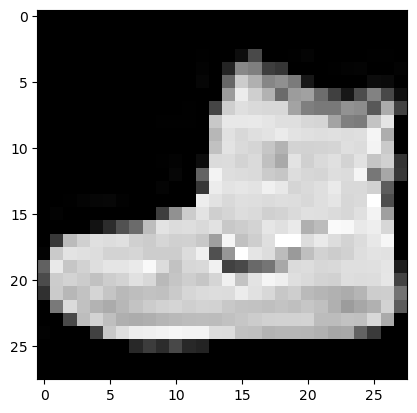

Label:  9


In [22]:
images, labels = next(iter(train_dataloader))
print('Shape of input tensor:', list(images.shape))
ii = torch.reshape(images[0],(28,28))
plt.imshow(ii, cmap='gray')
plt.show()
print('Label: ', int(labels[0]))

### Creating Models
As we have in previous sections when learning Boolean functions, to define a neural network in PyTorch we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function (the constructor) and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [23]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

net = DeepNeuralNet(input_width=28 * 28, hidden_layer_profile=[512, 512], output_width=10).to(device)
print(net)

Using cpu device
DeepNeuralNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=512, out_features=10, bias=True)
  (output_activation): Identity()
)


### Optimising Model Parameters

As illustrated before, to train a model, we need a loss function and an optimiser.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(net.parameters(), lr=1e-3)

The training loop from above will serve us well even in our current tasks. We also check the model’s performance against the test dataset to ensure it is learning -- in order to do so, we re-define the `testing_loop` function we used to learn Boolean functions in the new context of image classification.

In [26]:
def testing_loop(dataloader, net,):
    size = len(dataloader.dataset)
    net.eval()
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = net(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return correct / size

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we would like to see the accuracy increase and the loss decrease with every epoch.

In [27]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loop(train_dataloader, net, loss_fn, optimiser)
    validation_accuracy = testing_loop(train_dataloader, net)
    print(f"Validation Accuracy: {validation_accuracy:.2%}\n")
print("Training Done!")

testing_accuracy = testing_loop(test_dataloader, net)
print(f"\nTest Accuracy: {testing_accuracy:.2%}")

Epoch 1
-------------------------------
loss: 2.299250  [ 6016/60000]
loss: 2.284195  [12032/60000]
loss: 2.271132  [18048/60000]
loss: 2.252668  [24064/60000]
loss: 2.225774  [30080/60000]
loss: 2.214300  [36096/60000]
loss: 2.210086  [42112/60000]
loss: 2.187889  [48128/60000]
loss: 2.163620  [54144/60000]
Validation Accuracy: 45.51%

Epoch 2
-------------------------------
loss: 2.123572  [ 6016/60000]
loss: 2.135936  [12032/60000]
loss: 2.122916  [18048/60000]
loss: 2.072897  [24064/60000]
loss: 2.013225  [30080/60000]
loss: 1.987481  [36096/60000]
loss: 1.978024  [42112/60000]
loss: 1.953083  [48128/60000]
loss: 1.922504  [54144/60000]
Validation Accuracy: 57.80%

Epoch 3
-------------------------------
loss: 1.811129  [ 6016/60000]
loss: 1.887199  [12032/60000]
loss: 1.864772  [18048/60000]
loss: 1.759312  [24064/60000]
loss: 1.670190  [30080/60000]
loss: 1.601280  [36096/60000]
loss: 1.586531  [42112/60000]
loss: 1.570195  [48128/60000]
loss: 1.600582  [54144/60000]


KeyboardInterrupt: 

We get an accuracy around 65 % which is much better than the 10 % we would get from random guessing.

**Exercise.** Play around with different learning setups. Modifying just the learning rate and the number of epochs, how high can you take the validation accuracy? While doing so, do you also observe similar improvements in the test accuracy? (Remember that you can adjust the verbosity level not to have to read through long listings).

In [ ]:
net = DeepNeuralNet(input_width=28 * 28, hidden_layer_profile=[512, 512], output_width=10).to(device)
optimiser = torch.optim.SGD(net.parameters(), lr=1e-3)
train(train_dataloader, net, loss_fn, optimiser, epochs=5, epoch_frequency=1, verbosity=2)

**Exercise.** Play around with the architecture of the neural network that you train. Adding more layers and more neurons, can you take the test performance even higher than in the previous exercise?

In [ ]:
# define the architecture of your neural network
best_net = DeepNeuralNet(input_width=28 * 28, hidden_layer_profile=[ None ], output_width=10).to(device)
optimiser = torch.optim.SGD(best_net.parameters(), lr=1e-3)
print(best_net)

# train it
train(train_dataloader, best_net, loss_fn, optimiser, epochs, verbosity=3)

# test it
testing_accuracy = testing_loop(test_dataloader, best_net)
print(f"\nTest Accuracy: {testing_accuracy:.2%}")

### Saving and Loading Models
Quite often you want to save your model, either to be later deployed in practice (on a website or in a mobile device, for example), or to be able to evaluate it later, in a different workflow. A common way to save a model is to serialise the internal state dictionary (containing the model parameters).

In [ ]:
torch.save(net.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [ ]:
model = DeepNeuralNet(28 * 28, [512, 512], 10)
model.load_state_dict(torch.load("model.pth"))

This model can now be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred.argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')